In [1]:
# Calculate the Reflux Coefficient from TEF
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import TEF_Variables as tef

In [2]:
def reflux(Qsg, hs, xi):

    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
    # Confine to the range of fjord
    state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))


    s = state.S.data.mean(2) # Salinity in T,Z,X
    u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
    ot = state.T.data # Time in seconds


    HFacC1 = grid.HFacC.data.mean(1)
    dyF1 = grid.dyF.data.mean(0)
    drF1 = grid.drF.data
    gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
    da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

    S = state.S.data
    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    
    Qin = np.empty(len(xi))
    Qout = np.empty(len(xi))
    Sin = np.empty(len(xi))
    Sout = np.empty(len(xi))

    for i in range(len(xi)):
    
        tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1 = tef.process_section(U,S,DA,ot,xi[i],23,testing=False)

        qin1, qout1, sin1, sout1 = tef.bulk_calc(tef_q1, tef_vel1, tef_da1, tef_qs1, tef_qs21, sbins1, ot)
    
        Qin[i] = qin1[274:].mean() # Time averaging from 1+274 hour
        Qout[i] = qout1[274:].mean()
        Sin[i] = sin1[274:].mean() # Time averaging from 1+274 hour
        Sout[i] = sout1[274:].mean()
        
    #a00 = (Sin[0]/Sout[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    a00 = (Qin[0]-Qin[1]) / Qin[0]    
    a11 = (Sout[1]/Sin[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])    
    a01 = (Sout[1]/Sout[0])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    a10 = (Sin[0]/Sin[1])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    
    #a00 = -(Qout[0]/Qin[0])*(Sout[1]-Sout[0])/(Sout[1]-Sin[0])
    #a11 = -(Qin[1]/Qout[1])*(Sin[1]-Sin[0])/(Sout[1]-Sin[0])
    #a01 = (Qin[1]/Qin[0])*(Sout[1]-Sin[1])/(Sout[1]-Sin[0])
    #a10 = (Qout[0]/Qout[1])*(Sout[0]-Sin[0])/(Sout[1]-Sin[0])
    
    q0 = Qin[0]
    q1 = -Qout[-1]
    Q0 = -Qout[0]
    Q1 = Qin[-1]
    f0 = Sin[0]*q0
    f1 = Sout[-1]*q1
    F0 = Sout[0]*Q0
    F1 = Sin[-1]*Q1
    
    A = np.array([[q1, q0, 0, 0], [f1, f0, 0, 0], [0, 0, q1, q0], [0, 0, f1, f0]])
    B = np.array([Q1, F1, Q0, F0])
    X = np.linalg.solve(A,B)
    
    return a00, q0, q1, Q0


In [3]:
def vol_temp(Qsg, hs, xi):
    
    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
    # Confine to the range of fjord
    state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
    grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    
    drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
    dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
    HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
    DA = drF * dyF * HFacC
    
    da = DA[274:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    s = state.S.data[274:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    temp = state.Temp.data[274:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    u = U[274:,:,:,xi[0]+1:xi[1]+1].mean(axis=(0,2))
    sma = np.ma.masked_where(s==0, s)
    topo = np.ma.getmask(sma) # Masked Topography
    uma = np.ma.MaskedArray(u, mask=topo)
    tma = np.ma.MaskedArray(temp, mask=topo)
    
    #HFacC = grid.HFacC.data
    #CV = np.broadcast_to(grid.drF.data[:, np.newaxis, np.newaxis], HFacC.shape) * np.broadcast_to(grid.rA.data[np.newaxis, :, :], HFacC.shape) * HFacC # Cell Volume
    
    Tv1 = np.empty(uma.shape[1])
    Tv2 = np.empty(uma.shape[1])
    
    for i in range(uma.shape[1]):
            
        if any(uma[:,i]<0)==False:
            pass
            
        else:
            l = np.where(uma[:,i] < 0)[-1][0]    
            Tv1[i] = np.sum(tma[:l,i]*da[:l,i]*uma[:l,i]) / np.sum(da[:l,i]*uma[:l,i])
            Tv2[i] = np.sum(tma[l:,i]*da[l:,i]*uma[l:,i]) / np.sum(da[l:,i]*uma[l:,i])
            
        Tf = Tv1[:-1].mean()
        Ts = Tv2[:-1].mean()
        Ts_in = Tv2[-1]
            
    return Tf, Ts, Ts_in

In [4]:
Qsg = 700
hs = np.array([9,12,15,18])
xrange = np.array([47,72])

rflx = np.empty(len(hs))
Qin0 = np.empty(len(hs))
Qin1 = np.empty(len(hs))
Qout0 = np.empty(len(hs))
Ts = np.empty(len(hs))
Tf = np.empty(len(hs))
Ts_in = np.empty(len(hs))

for j in range(len(hs)):
    
    rflx[j], Qin0[j], Qin1[j], Qout0[j] = reflux(Qsg,hs[j],xrange)
    
    Tf[j], Ts[j], Ts_in[j] = vol_temp(Qsg,hs[j],xrange)

  time 0 out of 336
  time 0 out of 336


/Users/weiyangbao/Documents/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/Users/weiyangbao/Documents/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


  time 0 out of 336
  time 0 out of 336
  time 0 out of 336
  time 0 out of 336
  time 0 out of 336
  time 0 out of 336


Text(6.8999999999999995, 8.75, '$\\frac{h_s}{h}$')

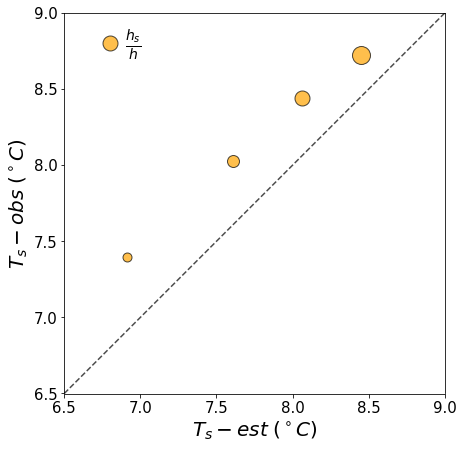

In [22]:
Tse = (Ts_in*Qin1 + Tf*Qin0*rflx) / Qout0

fig1, ax1 =plt.subplots(figsize=(10,7))



plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$T_s-est\;(^\circ C)$', size=20)
plt.ylabel(r'$T_s-obs\;(^\circ C)$', size=20)


for j in range(len(hs)):

    ax1.plot(Tse[j], Ts[j], marker='o', alpha=.7, ms=3*(j+3), color='orange', markeredgecolor='k')

ax1.set(xlim=(6.5, 9), ylim=(6.5, 9))
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
loc_mark = [6.8, 8.8]
plt.plot(loc_mark[0],loc_mark[1], marker='o', alpha=.7, ms=15, color='orange', markeredgecolor='k')
plt.text(loc_mark[0]+0.1, loc_mark[1]-0.05, r'$\frac{h_s}{h}$', fontsize=20)


In [15]:
Tse, Ts

(array([6.91355312, 7.61066222, 8.0636339 , 8.45222259]),
 array([7.39375254, 8.0275618 , 8.44129221, 8.72635756]))